# Behavioural Cloning: Implementing NVIDIA's Self-Driving Car Model

**This project aims to develop a self-driving car implementing NVIDIA's End-to-End Deep Learning Model.**

## 1. Importing Data

In [1]:
!git clone https://github.com/aviralchharia/Behavioral-Cloning

Cloning into 'Behavioral-Cloning'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 12183 (delta 6), reused 0 (delta 0), pack-reused 12166
Receiving objects: 100% (12183/12183), 157.16 MiB | 35.48 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (12165/12165), done.


In [2]:
!ls Behavioral-Cloning

'Block Diagram of Drive Simulator.JPG'	 README.md
'CNN Architecture.JPG'			'Training Images'
 Model.JPG				 driving_log.csv
'Neural Network Model.JPG'


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [4]:
datadir = 'Behavioral-Cloning'
columns = ['center', 'left', 'right', 'steering','throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

## 2. Data Visualization by Histogram between Frequency of Occurance vs Steering Angles

<BarContainer object of 25 artists>

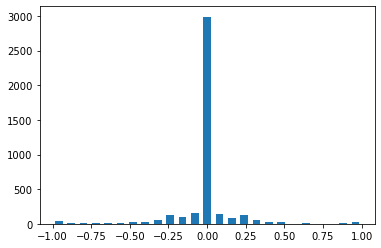

In [5]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)

**Since most of the time the car was driven in the middle of the track, a large frequency of data with steering angle = 0 is obtained & data imbalance occurs. This imbalance needs to be corrected or else the neural network model will be biased to move in the center of the track & would not be able to perform when encountered a turn. Therefore, we remove all the samples with steering angles = 0 above a certain threshold (here, 400)**

## 3. Balancing Data

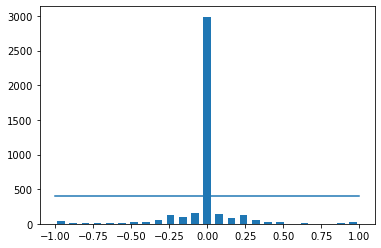

In [6]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2590
remaining: 1463


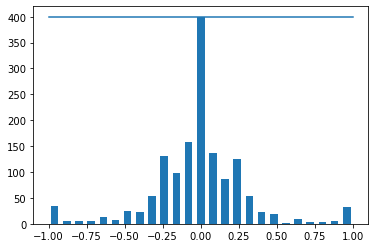

In [7]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_) 
  # We shuffle the list so that the threshold removes data from all parts of track 
  # rather than from one specific part of the track example on a bridge, etc.
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

**Thus the data has been balanced as shown in the plot above**

## 4. Training & Validation Split

In [8]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/Training Images', data)

center      center_2018_07_16_17_11_43_930.jpg
left          left_2018_07_16_17_11_43_930.jpg
right        right_2018_07_16_17_11_43_930.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                 0.610506
Name: 5, dtype: object


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

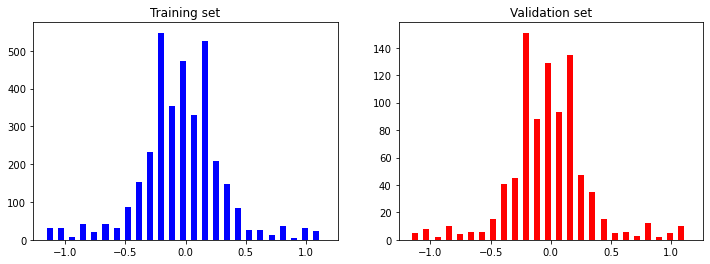

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## 5. Pre-processing Image

### 5.1. Adding Zoom

In [11]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

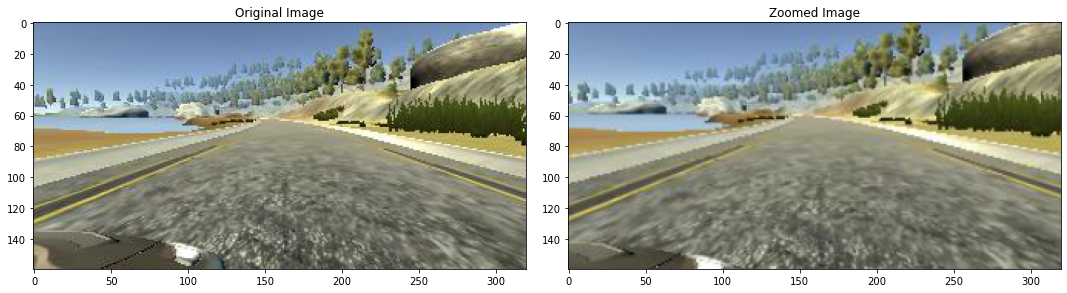

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

### 5.2. Adding Pan

In [13]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

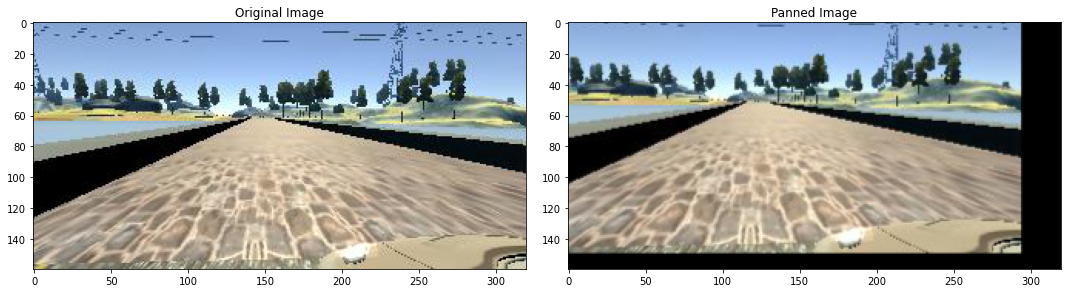

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

### 5.3. Altering Brightness

In [15]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

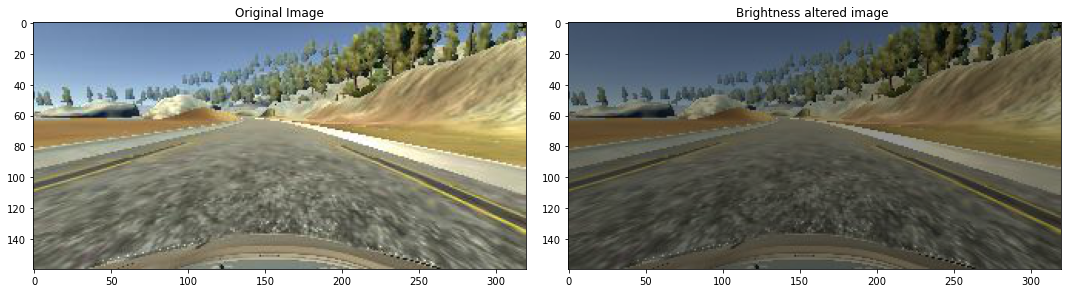

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

### 5.4. Flipping Steering Angle

In [17]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.25')

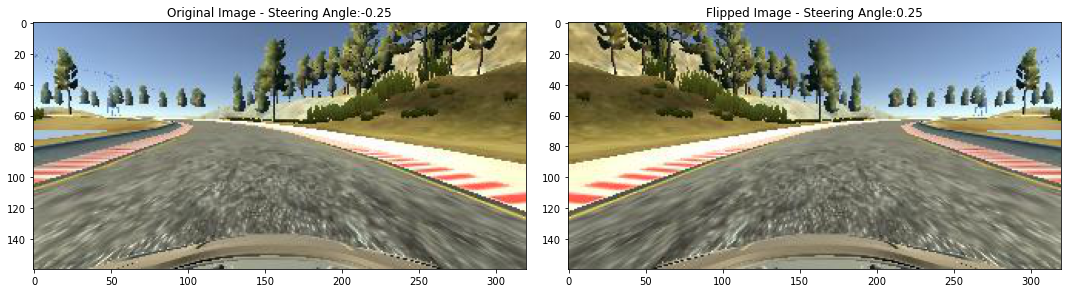

In [18]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

### 5.5. Random Augmentation

In [19]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

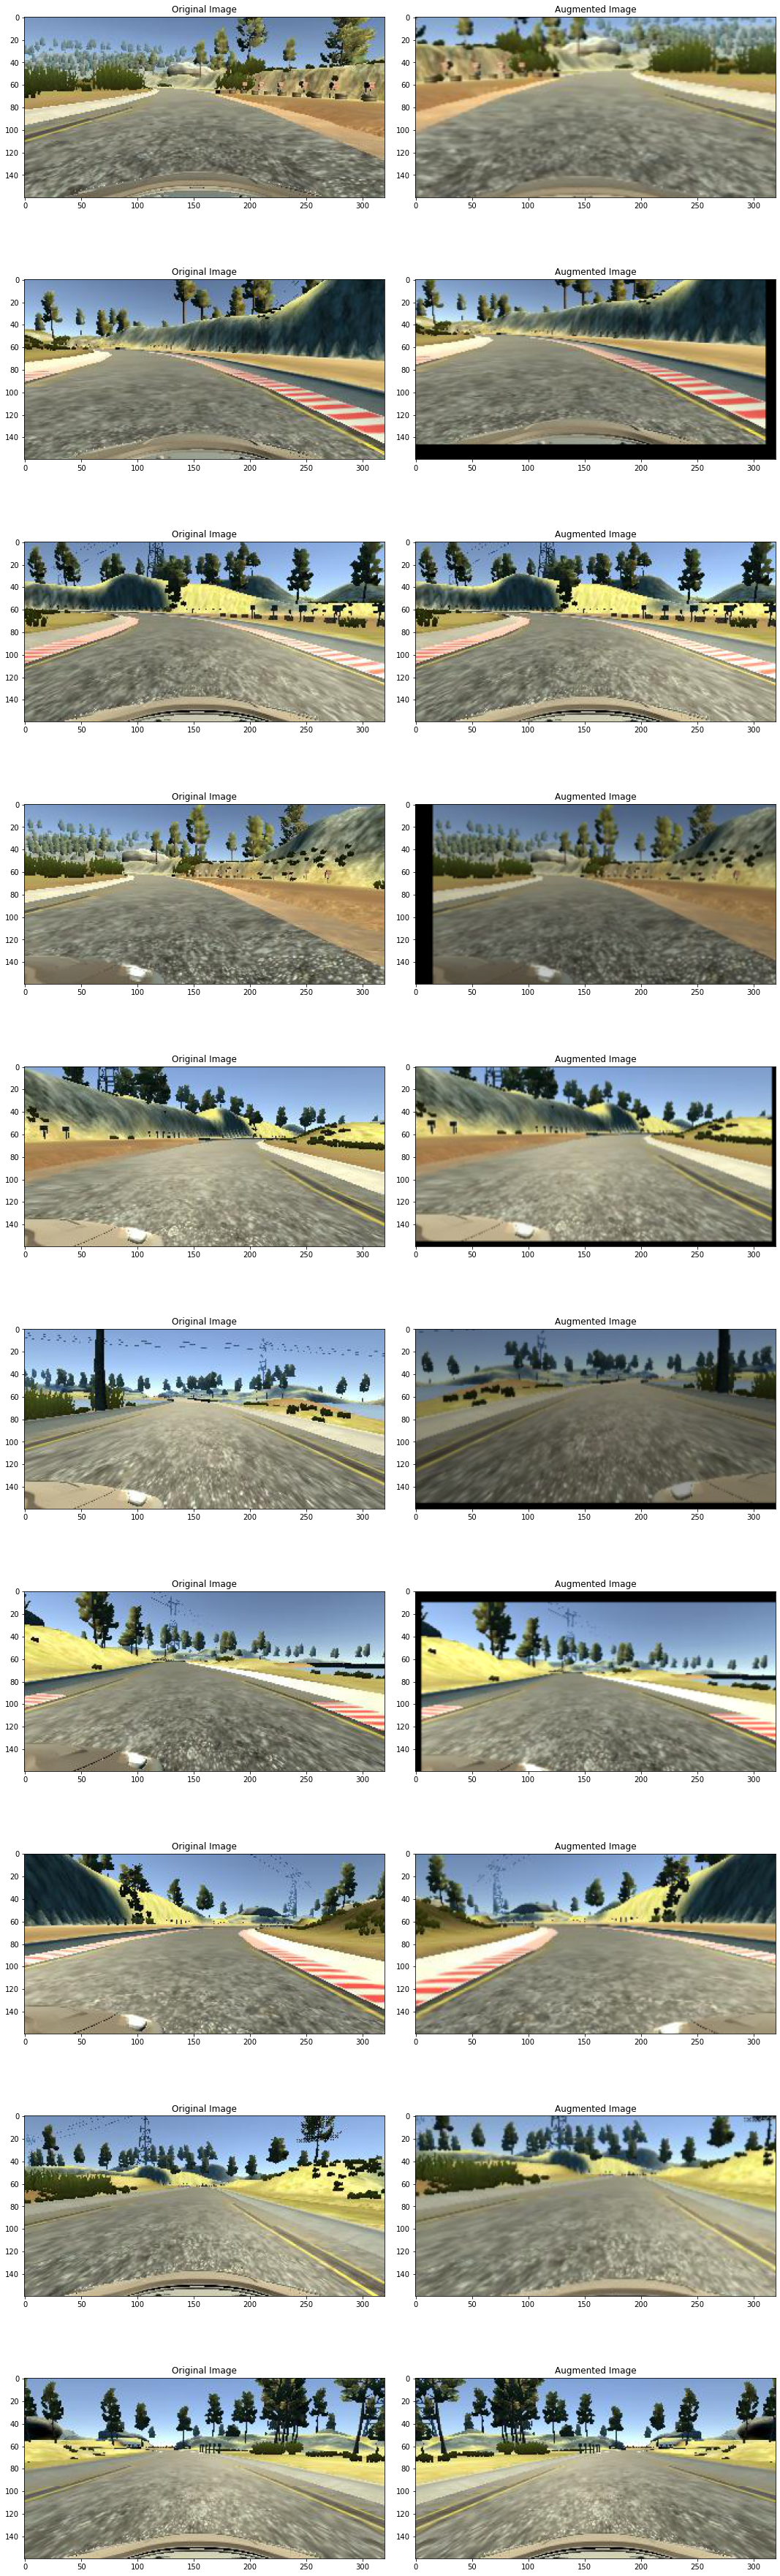

In [20]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

### 5.6. Adding Gaussian Blur, Changing RGB2YUV & Normalization

In [21]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

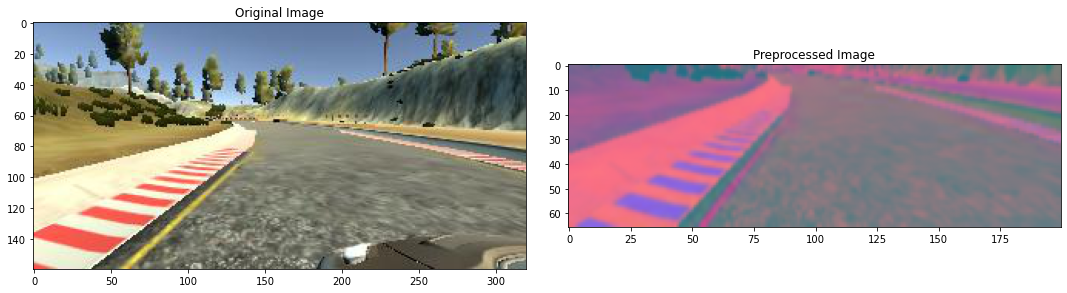

In [22]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [23]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

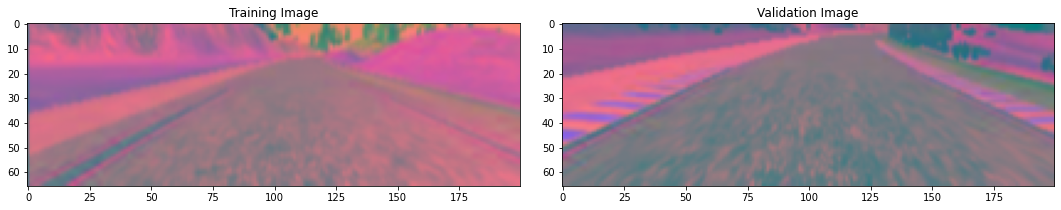

In [24]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

## 6. NVIDIA CNN Architecture

In [28]:
def nvidia_model():
 
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation ='relu'))
  model.add(Dense(1))
  optimizer= Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [29]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

## 7. Training the Model

In [30]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 154s 514ms/step - loss: 0.1180 - val_loss: 0.1073
Epoch 2/10
300/300 [==============================] - 156s 522ms/step - loss: 0.0917 - val_loss: 0.0508
Epoch 3/10
300/300 [==============================] - 154s 512ms/step - loss: 0.0646 - val_loss: 0.0456
Epoch 4/10
300/300 [==============================] - 155s 516ms/step - loss: 0.0582 - val_loss: 0.0398
Epoch 5/10
300/300 [==============================] - 154s 514ms/step - loss: 0.0535 - val_loss: 0.0347
Epoch 6/10
300/300 [==============================] - 151s 504ms/step - loss: 0.0511 - val_loss: 0.0368
Epoch 7/10
300/300 [==============================] - 148s 493ms/step - loss: 0.0478 - val_loss: 0.0317
Epoch 8/10
300/300 [==============================] - 150s 499ms/step - loss: 0.0459 - val_loss: 0.0325
Epoch 9/10
300/300 [==============================] - 149s 496ms/step - loss: 0.0442 - val_loss: 0.0302
Epoch 10/10
300/300 [==============================] - 150s 500m

## 8. Analysing Training Loss & Validation Loss Curves

Text(0.5, 0, 'Epoch')

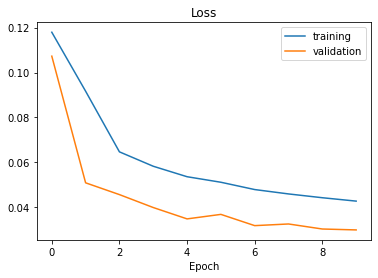

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
model.save('model.h5')